In [1]:
import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import pandas as pd

## Visualizing Training Data

In [3]:
import numpy as np

In [4]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [5]:
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")



In [6]:
test = pd.read_csv('test.csv')
test['sign_ord'] = test['sign'].astype('category').cat.codes


SIGN2ORD = test[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = test[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_df = pd.read_csv('test.csv')

# Initialize lists to store all predictions and true labels
all_preds = []
all_true_labels = []

correct_predictions = 0
total_predictions = len(test_df)

for index, row in test_df.iterrows():
    pq_file = row['path']  # Path to the parquet file
    true_label = row['sign']  # Actual label
    
    # Load the relevant data subset from the Parquet file
    xyz_np = load_relevant_data_subset(pq_file)
    
    # Make a prediction
    prediction = prediction_fn(inputs=xyz_np)
    pred = prediction['outputs'].argmax()
    sign = ORD2SIGN[pred]  # Convert prediction index to sign label
    #pred_conf = prediction['outputs'][pred]
    
    # Compare prediction to actual label
    if sign == true_label:
        correct_predictions += 1

    # Store predictions and actual labels
    all_preds.append(sign)
    all_true_labels.append(true_label)

# Convert lists to numpy arrays for scikit-learn compatibility
all_preds = np.array(all_preds)
all_true_labels = np.array(all_true_labels)

# Calculate precision, recall, and F1 score
# Note: Set average='macro' for unweighted mean per class, 'micro' for total ratio of sums, or 'weighted' for weighted mean per class
precision = precision_score(all_true_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_true_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_true_labels, all_preds, average='macro', zero_division=0)

# Print the results
# Calculate accuracy
accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9948
Precision: 0.9950
Recall: 0.9950
F1 Score: 0.9943


In [8]:
!pip install seaborn --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


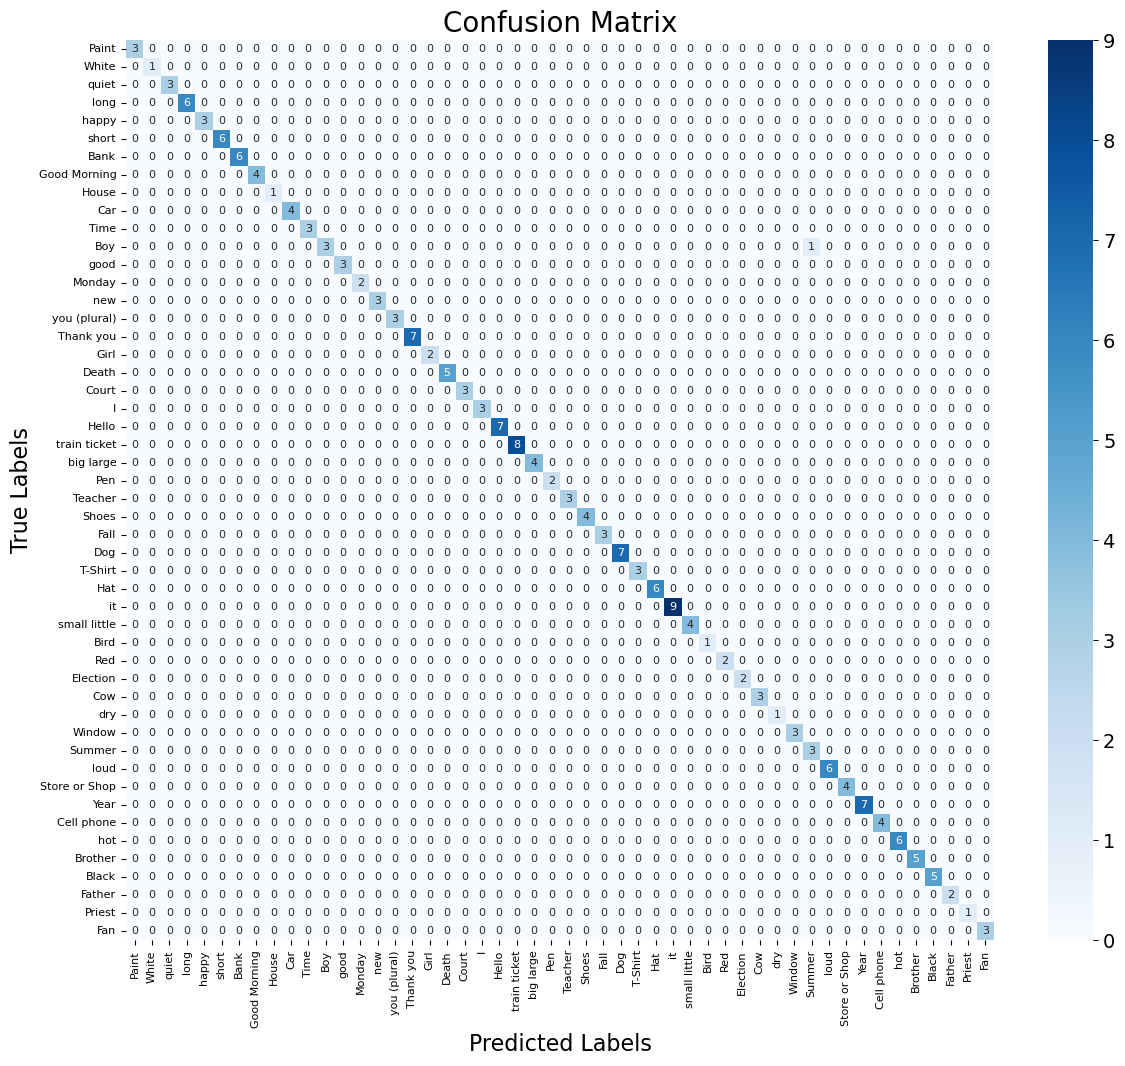

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_preds, labels=list(ORD2SIGN.values()))

plt.figure(figsize=(14, 12))  # Increase figure size for better visibility
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=ORD2SIGN.values(), yticklabels=ORD2SIGN.values(),
                 annot_kws={"size": 8})  # Make annotation (digits) smaller

# Rotate the tick labels for better visibility
plt.xticks(rotation=90, fontsize=8)  # Rotate x labels and make them smaller
plt.yticks(rotation=0, fontsize=8)  # Make y labels smaller

plt.title('Confusion Matrix', size=20)  # Adjust title size
plt.xlabel('Predicted Labels', size=16)  # Adjust x-axis label size
plt.ylabel('True Labels', size=16)  # Adjust y-axis label size

# Increase spacing to prevent clipping of tick labels
plt.subplots_adjust(bottom=0.2, top=0.95)

plt.show()